In [159]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn import model_selection
from sklearn import ensemble,tree,metrics
from xgboost import XGBClassifier

In [91]:
'HDF ist ein deutlich besseres Format als csv/txt/... -> Dateitypen + Index bleibt erhalten '
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5")
#predictor.info()
predictor.columns

Index(['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed',
       'mean_wind_direction', 'max_value_wind_direction',
       'max_hour_wind_direction', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 'mean_uv_radiation', 'max_value_uv_radiation',
       'max_hour_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 'rain_bool', 't_minmax',
       'demand_electricity', 'net_generation_electricity', 'day_of_week',
       'month', 'quarter', 'year', 'business_day', 'temp_bool', 'wind_bool',
       'humidity_bool', 'radiation_bool', 'tminmax_bool'],
      dtype='object')

In [92]:
pollution.columns

Index(['mean_co', 'max_value_co', 'max_hour_co', 'mean_so2', 'max_value_so2',
       'max_hour_so2', 'mean_no2', 'max_value_no2', 'max_hour_no2', 'mean_o3',
       'max_value_o3', 'max_hour_o3', 'mean_pm2_5', 'aqi_pm2_5', 'aqi_so2',
       'aqi_no2', 'aqi_o3', 'aqi_idxmax', 'aqi_max'],
      dtype='object')

## Lineare Modelle zur Vorhersage der O3-Konzentration
### Preprocessing 
- entfernen aller nan-Werte 
- Standartisieren um zu gewährleisten das auch Feature mit kleiner Varianz gewichtet werden und mit anderen vergleichbar sind


In [93]:
#nur numerische Columns (ohne wind_direction da in Grad, ohne UV_radiation da sehr ähnlich zu radiation)
# auch ohne elektricity denn dadurch mehr Daten
numeric_columns=['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 
        'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',  'business_day']

quarter_dummi= pd.get_dummies(predictor["quarter"],prefix="quarter")
wind_dummi= pd.get_dummies(predictor["mean_wind_direction"],prefix="wind")
predict_today=predictor[numeric_columns]
predict_today = predict_today.join(quarter_dummi)
predict_today = predict_today.join(wind_dummi)

predict_today["business_day"]= predict_today["business_day"].astype(np.uint8)

# hinzufügen der Schadstoff Werte (ohne max_hour)
predict_today = predict_today.join(pollution.drop(['max_hour_co', 'max_hour_so2',
                                                   'max_hour_no2','max_hour_o3',"aqi_idxmax","aqi_max"],axis=1))

predict_today_dropna=predict_today.dropna()
predict_today_dropna.shape

(1275, 41)

In [94]:
#vorher Standartisieren
col_to_scale=[     'mean_wind_speed', 'max_value_wind_speed',  'max_hour_wind_speed',
                  'mean_temp',       'max_value_temp',        'max_hour_temp',
              'mean_humidity',   'max_value_humidity',    'max_hour_humidity',
             'mean_radiation',  'max_value_radiation',   'max_hour_radiation',
              'mean_pressure',   'max_value_pressure',    'max_hour_pressure',
                       'rain',                't_max',                't_min',
                   't_minmax',              'mean_co',
               'max_value_co',             'mean_so2',        'max_value_so2',
                   'mean_no2',        'max_value_no2',              'mean_o3',
               'max_value_o3',           'mean_pm2_5']
st_scaler=StandardScaler()
predict_today_dropna[col_to_scale] = st_scaler.fit_transform(predict_today_dropna[col_to_scale])

predict_column="max_value_o3"
X_train , X_test , y_train , y_test = train_test_split(predict_today_dropna.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2','aqi_o3',predict_column,"mean_o3"],axis=1),
                                                       predict_today_dropna[predict_column])



/tmp/ipykernel_12331/601936574.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_today_dropna[col_to_scale] = st_scaler.fit_transform(predict_today_dropna[col_to_scale])


### OLS 
einfachstes lineares Modell, minimiert die Summer der Fehlerquadrate.  
Dabei sind insbesondere die Koeffizenten recht anschaulich um Zusammenhänge zu verstehen: So z.B. das bei hohen Temperaturen die O3-Konzentration steigt.

Score of the model: 0.7101408775845051


Text(0.5, 1.0, 'Koeffizenten des OLS-Modells')

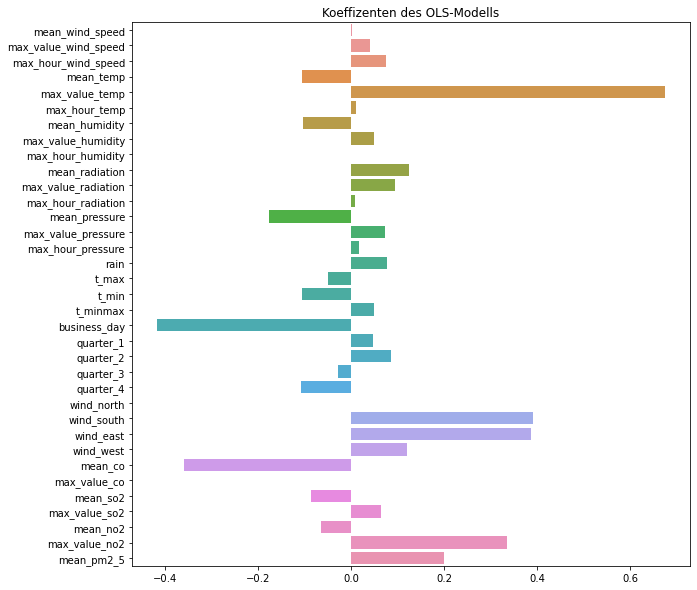

In [101]:
#einfachstes Modell -> linear
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
score= lin_reg.score(X_test,y_test)
print(f"Score of the model: {score}")
fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=lin_reg.coef_,orient="h")
ax_coef.set_title("Koeffizenten des OLS-Modells")

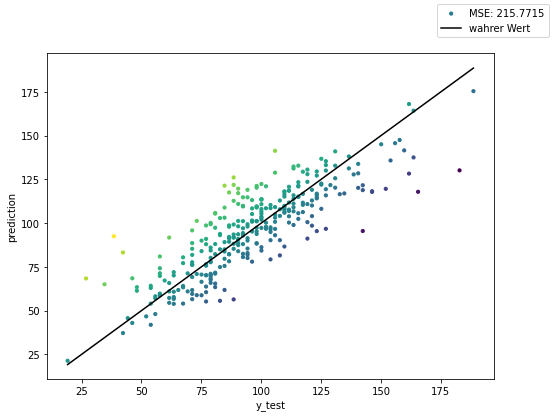

In [9]:
lin_reg_fig, lin_reg_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = lin_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true

mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
lin_reg_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
lin_reg_ax.plot(x,x,c="black",label="wahrer Wert")
lin_reg_ax.set_xlabel("y_test")
lin_reg_ax.set_ylabel("prediction")
lin_reg_fig.legend()


## Ridge Regression 
Dieses Modell ist sehr ähnlich zu OLS, versucht aber hohe Koeffizienten zu vermeiden -> kaum Unterschiede zum vorherigen Modell

Score of the model: 0.7092786792092864


(-0.45, 0.65)

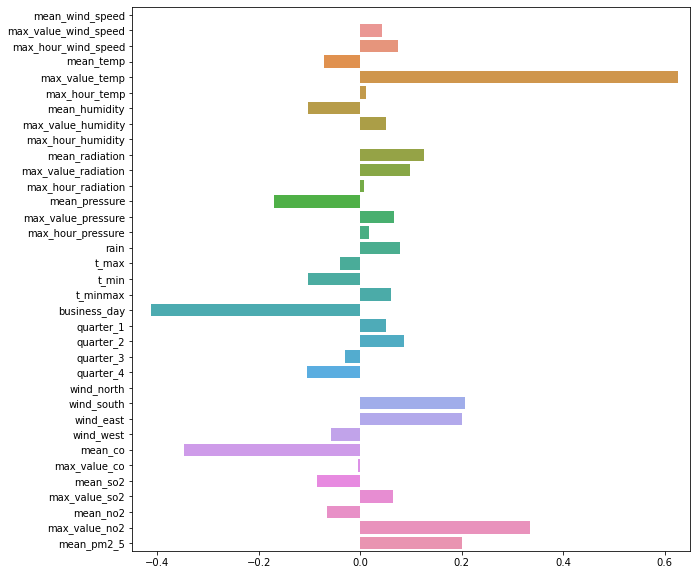

In [102]:
#anderes lineares Modell -> linear Ridge

ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
score= ridge_reg.score(X_test,y_test)
print(f"Score of the model: {score}")

fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=ridge_reg.coef_,orient="h")
ax_coef.set_xlim(-0.45,0.65)
ax_coef.set_title("Koeffizenten des Ridge-Regression-Modells")


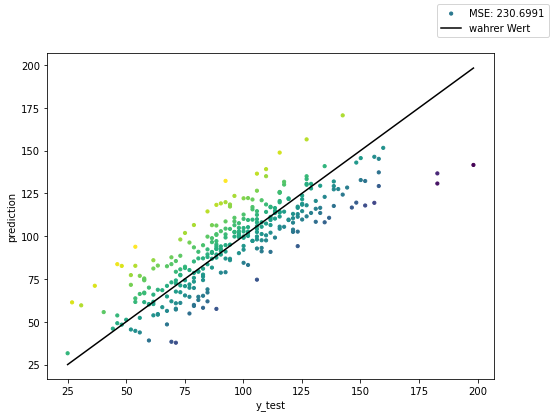

In [103]:
ridge_fig, ridge_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = ridge_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
ridge_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
ridge_ax.plot(x,x,c="black",label="wahrer Wert")
ridge_ax.set_xlabel("y_test")
ridge_ax.set_ylabel("prediction")
ridge_fig.legend()

Insgesamt ist das lineare Fitting nicht geeignet, da Underfitting zu beobachten ist. Im oben gezeigten Bild wäre eine Funtion mit mehr Freiheitsgeraden (z.B. mit x²-Term) bessere geeignet. 

## RandomForest Regressor

In [123]:
rfr=ensemble.RandomForestRegressor(random_state=1)
rfr_params={
    "criterion":["squared_error"],
    "n_estimators":[120],#125 
    "max_depth":[15], #15 is the best
    }

rfr_o3_search=model_selection.GridSearchCV(estimator=rfr,param_grid=rfr_params,scoring=["neg_mean_squared_error","explained_variance","r2"],refit="neg_mean_squared_error",
                                       verbose=2,n_jobs=4,cv=15)
rfr_o3_search.fit(X_train,y_train)

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   4.5s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.3s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.9s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   6.8s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   3.5s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.6s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.3s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   5.2s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   7.3s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   3.3s
[CV] END criterion=squared_error, max_depth=15, n_estimators=120; total time=   4.9s
[CV]

GridSearchCV(cv=15, estimator=RandomForestRegressor(random_state=1), n_jobs=4,
             param_grid={'criterion': ['squared_error'], 'max_depth': [15],
                         'n_estimators': [120]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=2)

{'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 120}
Score on the test Data
R2: 0.755882972531589


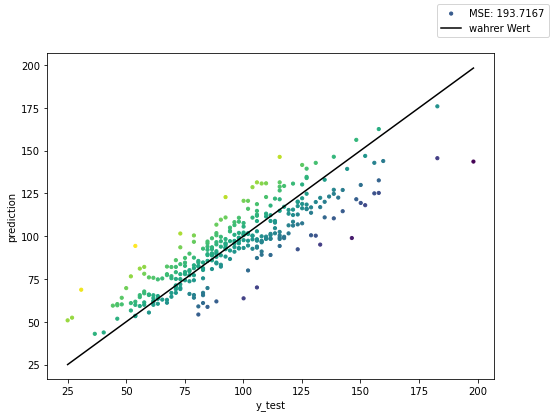

In [124]:
print(rfr_o3_search.best_params_)
rfr_fig, rfr_ax= plt.subplots(1,1,figsize=(8,6))
model=rfr_o3_search.best_estimator_

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = model.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
rfr_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
rfr_ax.plot(x,x,c="black",label="wahrer Wert")
rfr_ax.set_xlabel("y_test")
rfr_ax.set_ylabel("prediction")
rfr_fig.legend()
print("Score on the test Data")
print(f"R2: {metrics.r2_score(y_true,y_predict)}")

## Gradient Boosting Regression

In [110]:
gbr=ensemble.GradientBoostingRegressor(random_state=1)
gbr_params={
    "loss":["squared_error"],
    "n_estimators":[150],#150 
    "max_depth":[3], #3 is the best
    "learning_rate":[0.08] #0.08 is the best
    }

gbr_o3_search=model_selection.GridSearchCV(estimator=gbr,param_grid=gbr_params,scoring=["neg_mean_squared_error","explained_variance","r2"],refit="neg_mean_squared_error",
                                       verbose=2,n_jobs=4,cv=25)
gbr_o3_search.fit(X_train,y_train)

Fitting 25 folds for each of 1 candidates, totalling 25 fits
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   1.9s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   2.8s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   3.3s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   3.7s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   2.1s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   3.0s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   2.3s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   2.3s
[CV] END learning_rate=0.08, loss=squared_error, max_depth=3, n_estimators=150; total time=   3.3s
[CV] END learning_rate=0.08, loss=squared_error,

GridSearchCV(cv=25, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.08], 'loss': ['squared_error'],
                         'max_depth': [3], 'n_estimators': [150]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'explained_variance', 'r2'],
             verbose=2)

{'learning_rate': 0.08, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 150}
Score on the test Data
R2: 0.7651482999883505


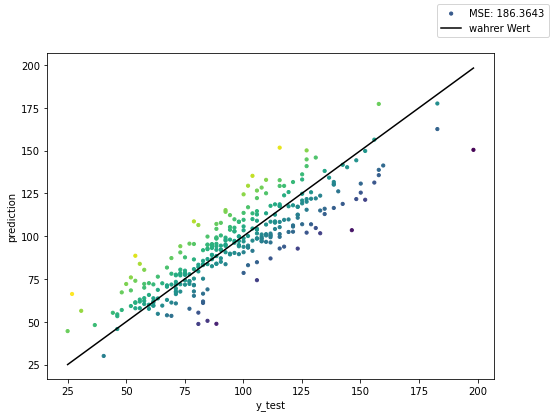

In [112]:
print(gbr_o3_search.best_params_)
gbr_fig, gbr_ax= plt.subplots(1,1,figsize=(8,6))
model=gbr_o3_search.best_estimator_

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = model.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
gbr_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
gbr_ax.plot(x,x,c="black",label="wahrer Wert")
gbr_ax.set_xlabel("y_test")
gbr_ax.set_ylabel("prediction")
gbr_fig.legend()
print("Score on the test Data")
print(f"R2: {metrics.r2_score(y_true,y_predict)}")

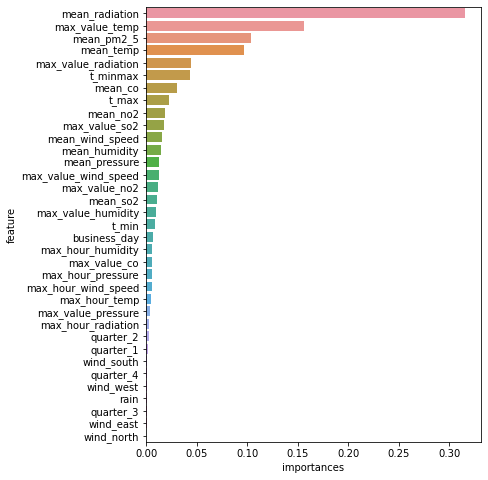

In [125]:
gbr_data=pd.DataFrame(data={"importances":rfr_o3_search.best_estimator_.feature_importances_,"feature":rfr_o3_search.best_estimator_.feature_names_in_})
gbr_data=gbr_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbr_data["importances"],y=gbr_data.feature,orient="h")

## Supervised Clustering with AQI O3
O3 bietet sich hierbei an, da dieser Schadstoff auch hohe AQI-Werte aufweist 

In [144]:
predict_column="aqi_o3"
X_train_classify , X_test_classify , y_train_classify , y_test_classify = train_test_split(predict_today_dropna.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2',predict_column,"mean_o3","max_value_o3"],axis=1),
                                                       predict_today_dropna[predict_column],random_state=1)
y_train_classify

2019-11-23        Fair
2017-03-12        Poor
2017-06-24    Moderate
2018-02-19        Fair
2017-12-09        Fair
                ...   
2018-04-19        Fair
2018-11-15        Fair
2019-06-10        Poor
2016-11-08    Moderate
2019-05-04    Moderate
Name: aqi_o3, Length: 956, dtype: category
Categories (6, object): ['Good' < 'Fair' < 'Moderate' < 'Poor' < 'Very Poor' < 'Extremely Poor']

In [130]:
rfc = RandomForestClassifier(max_depth=200,min_samples_split=10)
rfc.fit(X_train_classify,y_train_classify)
score= rfc.score(X_test_classify,y_test_classify)
print(f"Score of the model: {score}")


Score of the model: 0.7178683385579937


balanced score of the model: 0.5062976609589186
f1 score of the model: 0.6984825930059195
Test Score of the Models
score of the model: 0.71787
balanced score of the model: 0.5063
f1 score of the model: 0.69848


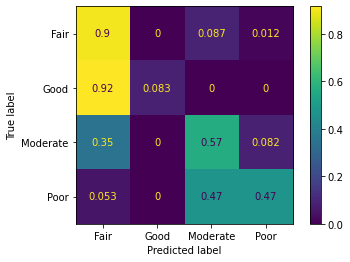

In [135]:
model=rfc
y_predict=model.predict(X_test_classify)
score_balanced= balanced_accuracy_score(y_true=y_test_classify,y_pred=y_predict)
print(f"balanced score of the model: {score_balanced}")
f1_score= metrics.f1_score(y_true=y_test_classify,y_pred=y_predict,average="weighted")
print(f"f1 score of the model: {f1_score}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

## Klassifikation mit KNN
hier wird KNN ohne vorherige Reduktion der Dimension durchgeführt

In [136]:
knn_solo=neighbors.KNeighborsClassifier()
param={
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    "metric" : ["cityblock","l2","cosine"]
    }
knn_search= model_selection.GridSearchCV(knn_solo,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
knn_search.fit(X_train_classify,y_train_classify)
knn_search_result=pd.DataFrame(knn_search.cv_results_)


 balanced score of the model: 0.5420436228531195
f1-Score: 0.6965959090903283
Test Score of the Models
score of the model: 0.67085
balanced score of the model: 0.47712
f1 score of the model: 0.65839


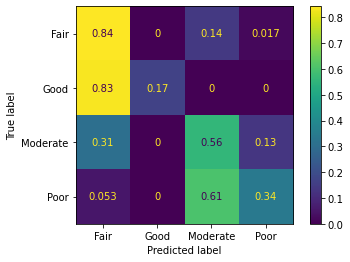

In [138]:
model=knn_search
y_predict=model.predict(X_test_classify)
score_balanced= knn_search_result.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f" balanced score of the model: {score_balanced}")
f1=knn_search_result.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {f1}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

### Pipeline mit PCA + KNN
üblicherweiße wird vor dem Clustern in großen Dimensionen eine Dimensionreduktion durchgeführt.
- Grund: Die meisten Features korrelieren miteinander -> beschreibung der Daten mit den sogenannten Hauptachsen (zeigen in Richtung der größten Varianz)
- Vorteile: Clustern ist schneller, Resistenter gegen Rauschen, ...

Text(0, 0.5, 'erklärte Varianz')

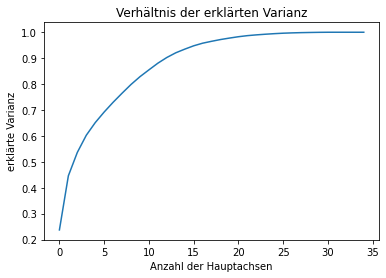

In [140]:
'erstes testen der PCA'
pca=decomposition.PCA()
'Important: only fit train data'
pca.fit(X_train_classify)

X_train_classify_pca=pca.transform(X_train_classify)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Verhältnis der erklärten Varianz")
plt.xlabel("Anzahl der Hauptachsen")
plt.ylabel("erklärte Varianz")


Es wird meist erwartet das sich die Daten mit einigen wenigen Achsen gut beschreiben lassen --> hier nicht der Fall
Gridsearch mit PCA und KNN -> dafür wird eine Pipeline erstellt
wie im [Beispiel](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) hier 
- Welche Metric ist die beste für Classifizierung ? [Medium Artikel](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- f1 scheint hierbei die beste Wahl zu sein, da sowohl Precision (Genauigkeit) und Recall (Sensitivität, Wahrscheinlichkeit das z.B. positiver Fall auch gefunden wird) berücksichtigt werden

In [141]:
pca_pipeline=decomposition.PCA()
knn_pipeline=neighbors.KNeighborsClassifier()

pipe=Pipeline(steps=[("pca",pca_pipeline),("knn",knn_pipeline)])
param={
    "pca__n_components": [1,4,8,11,12,13,14,15,16,17,23,30],
    'knn__n_neighbors': [2, 4, 6, 8],
    'knn__weights': ['uniform', 'distance'],
    "knn__metric" : ["cityblock","l2","cosine"]
    }
pca_knn_search= model_selection.GridSearchCV(pipe,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
pca_knn_search.fit(X_train_classify,y_train_classify)


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cityblock', 'l2', 'cosine'],
                         'knn__n_neighbors': [2, 4, 6, 8],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [1, 4, 8, 11, 12, 13, 14, 15, 16,
                                               17, 23, 30]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'])

The best parameters of the model are:
{'knn__metric': 'l2', 'knn__n_neighbors': 6, 'knn__weights': 'distance', 'pca__n_components': 16}
score of the model: 0.71338
balanced score of the model: 0.55003
f1-Score: 0.6966
Test Score of the Models
score of the model: 0.66458
balanced score of the model: 0.49247
f1 score of the model: 0.65595


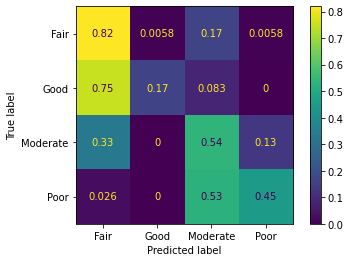

In [143]:
'Choose your model with tuned parameter with GridSearchCV'
model=pca_knn_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_classify,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_classify,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_classify,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")



cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

## Gradient Boosting Classifier


In [109]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "gbc__loss":["log_loss"],
    "gbc__n_estimators":[100,150],
    "gbc__max_depth":[2], #2 is the best
    "gbc__learning_rate":[0.1] #0.1 is the best
    }

pipeline_aqio3=Pipeline([("scaler",StandardScaler()),("gbc",gbc)])
gbc_seach=model_selection.GridSearchCV(estimator=pipeline_aqio3,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4)
gbc_seach.fit(X_train_classify,y_train_classify)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   4.1s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.7s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   4.0s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.9s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=100; total time=   5.5s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=   5.8s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=  10.3s
[CV] END gbc__learning_rate=0.1, gbc__loss=log_loss, gbc__max_depth=2, gbc__n_estimators=150; total time=   8.9s
[CV] END gbc__learning_rate=0.1, gbc

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=1))]),
             n_jobs=4,
             param_grid={'gbc__learning_rate': [0.1], 'gbc__loss': ['log_loss'],
                         'gbc__max_depth': [2],
                         'gbc__n_estimators': [100, 150]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'gbc__learning_rate': 0.1, 'gbc__loss': 'log_loss', 'gbc__max_depth': 2, 'gbc__n_estimators': 150}
score of the model: 0.74166
balanced score of the model: 0.59808
f1-Score: 0.6966


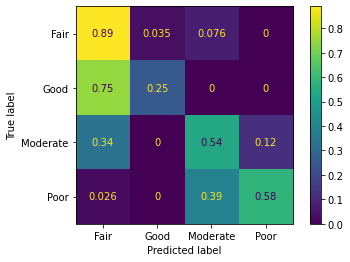

In [110]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_seach

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_classify)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(f1,5)}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

In [119]:
gbc_seach.best_estimator_["gbc"]

GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=1)

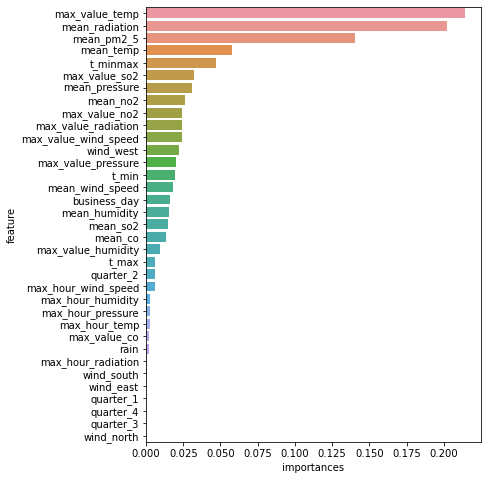

In [121]:
gbc_data=pd.DataFrame(data={"importances":gbc_seach.best_estimator_["gbc"].feature_importances_,"feature":gbc_seach.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")


# Vorhersage des AQI_max/AQI_O3 
**dazu werden nur CO-Messdaten verwendet** neben den anderen Meterologischen Daten usw. 

### Verbessert sich das Modell mit mehr Trainingsdaten?
- vorher nur ca. 1300 Datenpunkte -> nach dem Imputer ca. 3000
- Dazu müssen die fehlenden Daten mit einem Imputer clever ergänzt werden 
- einige GradientBoostingClassifier Algorithmen unterstützen auch nan-Werte, diese werden hier aber nicht verwendet.

In [5]:
'Try to input missing values'
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
col_tofill=['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 
        'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',  'business_day']
predict_na_filled=predict_today
predict_na_filled= pd.DataFrame(IterativeImputer(verbose=1,max_iter=30).fit_transform(predict_today[col_tofill]),columns=col_tofill,index=predict_today.index)
predict_na_filled = predict_na_filled.join(pollution[['mean_co','max_value_co']])
predict_na_filled[predict_na_filled.columns] = StandardScaler().fit_transform(predict_na_filled)
predict_na_filled = predict_na_filled.join(pollution[["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"]])
predict_na_filled = predict_na_filled.dropna()
predict_na_filled.info()

[IterativeImputer] Completing matrix with shape (4017, 20)
[IterativeImputer] Change: 66.64872594212545, scaled tolerance: 1.317 
[IterativeImputer] Change: 43.8360172053147, scaled tolerance: 1.317 
[IterativeImputer] Change: 36.66441711471834, scaled tolerance: 1.317 
[IterativeImputer] Change: 30.251580172739068, scaled tolerance: 1.317 
[IterativeImputer] Change: 26.10505777688959, scaled tolerance: 1.317 
[IterativeImputer] Change: 22.5612552217351, scaled tolerance: 1.317 
[IterativeImputer] Change: 19.631087703783244, scaled tolerance: 1.317 
[IterativeImputer] Change: 17.043103233604768, scaled tolerance: 1.317 
[IterativeImputer] Change: 14.696322920962261, scaled tolerance: 1.317 
[IterativeImputer] Change: 12.611304458615797, scaled tolerance: 1.317 
[IterativeImputer] Change: 10.768470505804341, scaled tolerance: 1.317 
[IterativeImputer] Change: 9.158513027023826, scaled tolerance: 1.317 
[IterativeImputer] Change: 7.769501935671726, scaled tolerance: 1.317 
[IterativeImpu

In [72]:
'Drop the Columns with "very poor" AQI -> only 7 times '
print(predict_na_filled[predict_na_filled["aqi_max"]=="Very Poor"].shape) #7 times
'Only 7 times "Very Poor", therfore delete these rows'
predict_na_filled = predict_na_filled.drop(predict_na_filled[predict_na_filled["aqi_max"]=="Very Poor"].index)
predict_na_filled[predict_na_filled["aqi_max"]=="Very Poor"].shape

(0, 26)


(0, 26)

In [145]:
predict_column="aqi_o3"
X_train_aqio3 , X_test_aqio3 , y_train_aqio3 , y_test_aqio3 = train_test_split(predict_na_filled.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"],axis=1),
                                                       predict_na_filled[predict_column],random_state=1)
X_train_aqio3.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3091 entries, 2010-01-01 to 2022-06-30
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mean_wind_speed       3091 non-null   float64 
 1   max_value_wind_speed  3091 non-null   float64 
 2   max_hour_wind_speed   3091 non-null   float64 
 3   mean_temp             3091 non-null   float64 
 4   max_value_temp        3091 non-null   float64 
 5   max_hour_temp         3091 non-null   float64 
 6   mean_humidity         3091 non-null   float64 
 7   max_value_humidity    3091 non-null   float64 
 8   max_hour_humidity     3091 non-null   float64 
 9   mean_radiation        3091 non-null   float64 
 10  max_value_radiation   3091 non-null   float64 
 11  max_hour_radiation    3091 non-null   float64 
 12  mean_pressure         3091 non-null   float64 
 13  max_value_pressure    3091 non-null   float64 
 14  max_hour_pressure     3091 non-null   

Index(['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed',
       'mean_temp', 'max_value_temp', 'max_hour_temp', 'mean_humidity',
       'max_value_humidity', 'max_hour_humidity', 'mean_radiation',
       'max_value_radiation', 'max_hour_radiation', 'mean_pressure',
       'max_value_pressure', 'max_hour_pressure', 'rain', 't_max', 't_min',
       't_minmax', 'business_day', 'mean_co', 'max_value_co'],
      dtype='object')

In [8]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[200],
    "max_depth":[2], #2 is the best
    "learning_rate":[0.1] #0.1 is the best
    }

gbc_o3_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
gbc_o3_search.fit(X_train_aqio3,y_train_aqio3)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  15.3s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  18.5s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  19.1s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  23.9s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  15.3s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [2], 'n_estimators': [200]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 200}
score of the model: 0.69695
balanced score of the model: 0.50493
f1-Score: 0.68586


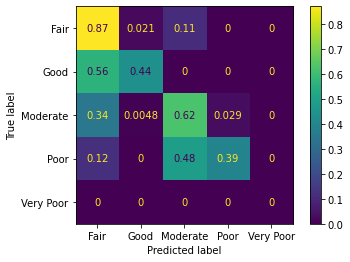

In [13]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_o3_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqio3)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")
'Print the scores'
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}")

cm=confusion_matrix(y_true=y_test_aqio3,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

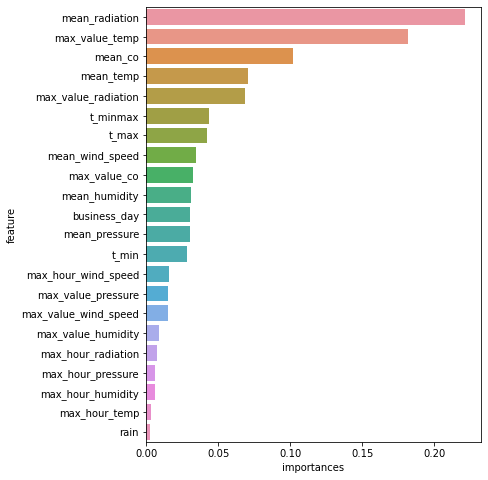

In [221]:
gbc_data=pd.DataFrame(data={"importances":gbc_no2_search.best_estimator_.feature_importances_,"feature":gbc_no2_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")

## Predict the max AQI Index
- dabei werden auch die ergänzten Daten aus dem Imputer verwendet



In [191]:
columns_highly_relevant=["max_value_temp","mean_radiation","mean_temp","t_minmax","mean_pressure","mean_co","max_value_co","max_value_radiation","mean_wind_speed"]
predict_nafilled_morefeatures=predict_na_filled
#increase datetime index by one day
for today in [-1,-2]:
    df_relevant=predict_na_filled[columns_highly_relevant]
    df_relevant.index=df_relevant.index+ datetime.timedelta(days=-today)
    df_relevant.columns = [f"{old_col}_today{today}" for old_col in df_relevant.columns]
    predict_nafilled_morefeatures=predict_nafilled_morefeatures.join(df_relevant)
print(f"Shape: {predict_nafilled_morefeatures.shape}")
predict_nafilled_morefeatures.dropna(axis=0,inplace=True)
print(f"Shape after dropna: {predict_nafilled_morefeatures.shape}")

Shape: (3091, 44)
Shape after dropna: (2655, 44)


In [192]:
predict_column="aqi_max"
#standart features
X_train_aqimax , X_test_aqimax , y_train_aqimax , y_test_aqimax = train_test_split(predict_na_filled.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"],axis=1),
                                                       predict_na_filled[predict_column],random_state=1)


#### Modell ohne die zusätzlichen Features

In [203]:
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[200],
    "max_depth":[2], #2 is the best
    "learning_rate":[0.1] #0.1 is the best
    }

gbc_aqimax_search=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=5)
gbc_aqimax_search.fit(X_train_aqimax,y_train_aqimax)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  15.9s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  15.9s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.5s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  17.2s
[CV] END learning_rate=0.1, loss=log_loss, max_depth=2, n_estimators=200; total time=  11.7s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['log_loss'],
                         'max_depth': [2], 'n_estimators': [200]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 200}
Training Score of the models
score of the model: 0.70066
balanced score of the model: 0.61359
f1-Score: 0.69392
Test Score of the Models
score of the model: 0.71084
balanced score of the model: 0.64292
f1 score of the model: 0.70937


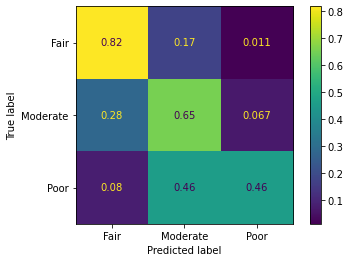

In [204]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_aqimax_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

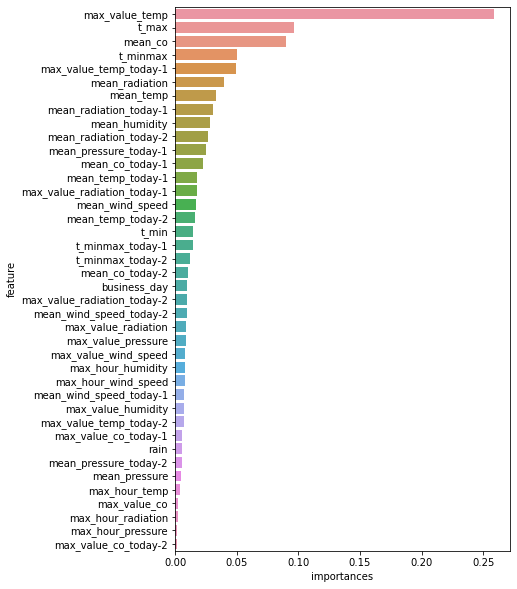

In [205]:
gbc_data=pd.DataFrame(data={"importances":gbc_aqimax_search.best_estimator_.feature_importances_,"feature":gbc_aqimax_search.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,10))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")

### verbessert sich die Modelle mit mehr Featuren? 
- dazu werden aus den Modellen oben einige wichtige Features ausgesucht und ergänzt. Dabei werden jedoch immer nur die Werte von einem Tag/zwei tage vorher verwendet. 
- Features die auf diesem Weg hinzugefügt werden: 
  * max_value_temp
  * mean_radiation
  * mean_temp
  * t_minmax
  * mean_pressure
  * mean_co
  * max_value_co
  * max_value_radiation
  * mean_wind_speed

In [212]:
'More features included'
X_train_aqimax_moref , X_test_aqimax_moref , y_train_aqimax_moref , y_test_aqimax_moref = train_test_split(predict_nafilled_morefeatures.drop(["aqi_max","aqi_no2","aqi_o3","aqi_pm2_5"],axis=1),
                                                       predict_nafilled_morefeatures[predict_column],random_state=1)
gbc=ensemble.GradientBoostingClassifier(random_state=1)
gbc_params={
    "loss":["log_loss"],
    "n_estimators":[100,110],
    "max_depth":[5], #2 is the best
    "learning_rate":[0.12] #0.1 is the best
    }

gbc_aqimax_search_moref=model_selection.GridSearchCV(estimator=gbc,param_grid=gbc_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=12)
gbc_aqimax_search_moref.fit(X_train_aqimax_moref,y_train_aqimax_moref)

Fitting 12 folds for each of 2 candidates, totalling 24 fits
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  19.5s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  27.0s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  27.7s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  31.3s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  19.9s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  23.4s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  26.9s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  24.3s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  23.6s
[CV] END learning_rate=0.12, loss=log_loss, max_depth=5, n_estimators=100; total time=  19.5s

GridSearchCV(cv=12, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.12], 'loss': ['log_loss'],
                         'max_depth': [5], 'n_estimators': [100, 110]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'learning_rate': 0.12, 'loss': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
Training Score of the models
score of the model: 0.70971
balanced score of the model: 0.625
f1-Score: 0.70183
Test Score of the Models
score of the model: 0.69277
balanced score of the model: 0.63253
f1 score of the model: 0.69363


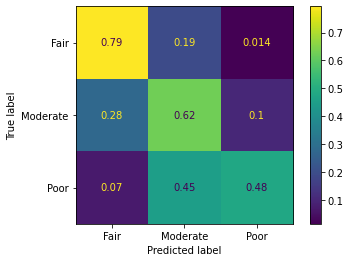

In [213]:
'Choose your model with tuned parameter with GridSearchCV'
model=gbc_aqimax_search_moref

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax_moref)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax_moref,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax_moref,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax_moref,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax_moref,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

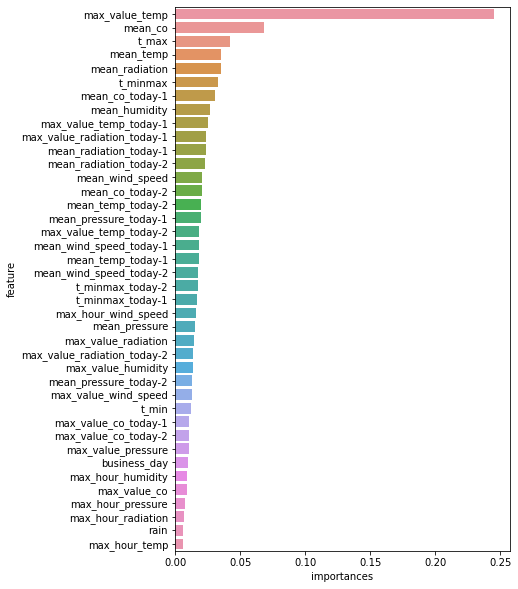

In [214]:
gbc_data=pd.DataFrame(data={"importances":gbc_aqimax_search_moref.best_estimator_.feature_importances_,"feature":gbc_aqimax_search_moref.best_estimator_.feature_names_in_})
gbc_data=gbc_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,10))
ax=sns.barplot(x=gbc_data["importances"],y=gbc_data.feature,orient="h")

--> die zusätzlichen Features ändern nur wenig an den Ergebnissen des Modells. 
Daher wird nachgehend darauf verzichtet und die normalen Daten verwendet. 

In [215]:
xgb=XGBClassifier(nthread=4,random_state=1)
xgb_params={
    "booster":["gbtree"], #gbtree is the best
    "eta":[0.1], #0.1
    "max_depth":[3] #3 
    }

xgb_aqimax_search=model_selection.GridSearchCV(estimator=xgb,param_grid=xgb_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,cv=15)
y_train_aqimax_integer=y_train_aqimax.cat.codes
xgb_aqimax_search.fit(X_train_aqimax,y_train_aqimax_integer)

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   4.0s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.4s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   4.1s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   4.2s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   4.2s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.0s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.8s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.7s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.3s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   4.1s
[CV] END ...............booster=gbtree, eta=0.1, max_depth=3; total time=   3.9s
[CV] END ...............booster=gbtree, eta=0.1,

GridSearchCV(cv=15,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'booster': ['gbtree'], 'eta': [0.1], 'max_depth': [3]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'booster': 'gbtree', 'eta': 0.1, 'max_depth': 3}
Training Score of the models
score of the model: 0.70272
balanced score of the model: 0.60424
f1-Score: 0.69299
Test Score of the Models
score of the model: 0.68675
balanced score of the model: 0.61848
f1 score of the model: 0.68727


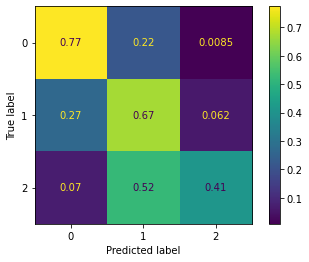

In [216]:
'Choose your model with tuned parameter with GridSearchCV'
model=xgb_aqimax_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)
print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax.cat.codes,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax.cat.codes,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax.cat.codes,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax.cat.codes,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

### Adaboost

In [217]:
adaboost=ensemble.AdaBoostClassifier(random_state=1)
adaboost_params={
    "estimator":[tree.DecisionTreeClassifier(criterion="gini",max_depth=3)],
    "n_estimators":[50], # 50 ist best
    "learning_rate":[0.1], #0.1 is the best
    }

adaboost_aqimax_search=model_selection.GridSearchCV(estimator=adaboost,param_grid=adaboost_params,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted",
                                       verbose=2,n_jobs=4,cv=20)
adaboost_aqimax_search.fit(X_train_aqimax,y_train_aqimax)

Fitting 20 folds for each of 1 candidates, totalling 20 fits
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.7s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.7s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   3.0s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   3.3s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.5s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.8s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.9s
[CV] END estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.1, n_estimators=50; total time=   2.9s
[CV] END estimator=DecisionTreeClassifier(max_depth

GridSearchCV(cv=20, estimator=AdaBoostClassifier(random_state=1), n_jobs=4,
             param_grid={'estimator': [DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.1], 'n_estimators': [50]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
             verbose=2)

The best parameters of the model are:
{'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 50}
Training Score of the models
score of the model: 0.67907
balanced score of the model: 0.56479
f1-Score: 0.66344
Test Score of the Models
score of the model: 0.64759
balanced score of the model: 0.56432
f1 score of the model: 0.64308


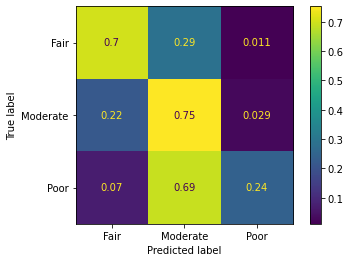

In [218]:
'Choose your model with tuned parameter with GridSearchCV'
model=adaboost_aqimax_search

model_search_results=pd.DataFrame(model.cv_results_)
y_predict=model.predict(X_test_aqimax)

print("The best parameters of the model are:")
print(model.best_params_,end="\n")

'Training Score of the models'
print("Training Score of the models")
score= model_search_results.sort_values("rank_test_accuracy")["mean_test_accuracy"].iloc[0]
print(f"score of the model: {round(score,5)}")
score_balanced= model_search_results.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f"balanced score of the model: {round(score_balanced,5)}")
score_f1=model_search_results.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {round(score_f1,5)}",end="\n")

'Test Score'
print("Test Score of the Models")
accuracy_test=metrics.accuracy_score(y_test_aqimax,y_predict)
print(f"score of the model: {round(accuracy_test,5)}")
balanced_accuracy_test=metrics.balanced_accuracy_score(y_test_aqimax,y_predict)
print(f"balanced score of the model: {round(balanced_accuracy_test,5)}")
f1_test=metrics.f1_score(y_test_aqimax,y_predict,average="weighted")
print(f"f1 score of the model: {round(f1_test,5)}")

cm=confusion_matrix(y_true=y_test_aqimax,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

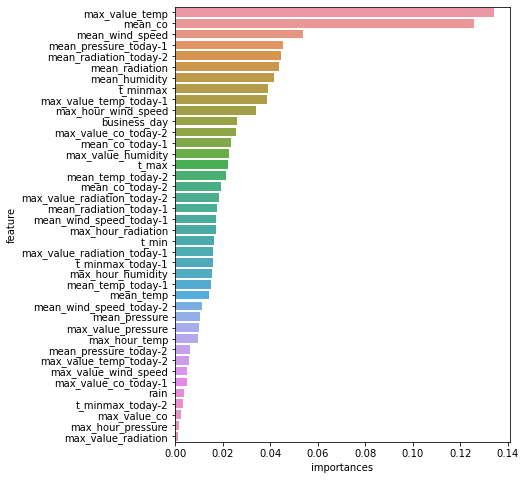

In [219]:
adaboost_data=pd.DataFrame(data={"importances":adaboost_aqimax_search.best_estimator_.feature_importances_,"feature":adaboost_aqimax_search.best_estimator_.feature_names_in_})
adaboost_data=adaboost_data.sort_values("importances",ascending=False)
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax=sns.barplot(x=adaboost_data["importances"],y=adaboost_data.feature,orient="h")